<a href="https://colab.research.google.com/github/grabuffo/BrainStim_ANN_fMRI_HCP/blob/main/notebooks/Fit_TMS_fMRI_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/grabuffo/BrainStim_ANN_fMRI_HCP/blob/main/notebooks/Fit_TMS_fMRI_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# --- Setup cell ---

# 1️⃣ Mount Google Drive (for data)
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# 2️⃣ Clone GitHub repository (for code)
import os, sys, subprocess

repo_dir = "/content/BrainStim_ANN_fMRI_HCP"
if not os.path.exists(repo_dir):
    !git clone https://github.com/grabuffo/BrainStim_ANN_fMRI_HCP.git
else:
    print("Repo already exists ✅")

# 3️⃣ Define paths (TMS-fMRI)
data_dir = "/content/drive/MyDrive/Colab Notebooks/Brain_Stim_ANN/data"
preproc_dir = os.path.join(data_dir, "preprocessed_subjects_tms_fmri")

# Where to save training outputs (kept separate from HCP)
weights_dir = os.path.join(preproc_dir, "trained_models_MLP_tms_fmri")
ects_dir    = os.path.join(preproc_dir, "ECts_MLP_tms_fmri")  # keep naming consistent with your convention
os.makedirs(weights_dir, exist_ok=True)
os.makedirs(ects_dir, exist_ok=True)

# 4️⃣ Add repo to import path + imports
sys.path.append(repo_dir)

import numpy as np
import matplotlib.pyplot as plt
import torch
from src import NPI
from src.preprocessing_tms_fmri import split_last_fraction, make_inputs_targets

import gc

# 5️⃣ Check device
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Running on:", torch.cuda.get_device_name(0))
else:
    print("⚠️  GPU not detected — training will run on CPU.")

Mounted at /content/drive
Cloning into 'BrainStim_ANN_fMRI_HCP'...
remote: Enumerating objects: 462, done.
remote: Counting objects: 100% (112/112), done.
remote: Compressing objects: 100% (102/102), done.
remote: Total 462 (delta 50), reused 10 (delta 10), pack-reused 350 (from 2)
Receiving objects: 100% (462/462), 62.70 MiB | 25.87 MiB/s, done.
Resolving deltas: 100% (158/158), done.
PyTorch version: 2.9.0+cu126
CUDA available: True
Running on: Tesla T4


In [2]:
# --- Training parameters ---

# Choose ANN architecture: 'MLP', 'CNN', 'RNN', or 'VAR'
method = "MLP"

# Data / model hyperparameters
ROI_num = 450         # Tian 50 + Schaefer 400
using_steps = 3       # S: number of past steps used to predict next step

# Training hyperparameters
batch_size = 64
num_epochs = 50
learning_rate = 5e-4
l2_reg = 5e-5

# Population split rule (fixed): last 10% within each participant is test
test_fraction = 0.10

print(f"Training configuration:")
print(f"  Dataset: TMS-fMRI (task-rest only), population model")
print(f"  Method: {method}")
print(f"  Regions: {ROI_num}")
print(f"  Steps: {using_steps}")
print(f"  Test fraction (per-subject): {test_fraction}")
print(f"  Epochs: {num_epochs}")
print(f"  Batch size: {batch_size}")


Training configuration:
  Dataset: TMS-fMRI (task-rest only), population model
  Method: MLP
  Regions: 450
  Steps: 3
  Test fraction (per-subject): 0.1
  Epochs: 50
  Batch size: 64



### Notes on the split (important)

We **do not** concatenate raw time series across participants.

Instead:
1. For each participant, we split the **filtered signals** into train/test by taking the **last 10%** as test.
2. We create **Inputs/Targets within each split**, so no sample ever crosses a subject boundary.
3. We then concatenate **samples** across participants to form population train and test sets.


In [3]:

# --- Build population train/test datasets from per-subject signals ---

import glob

signal_files = sorted(glob.glob(os.path.join(preproc_dir, "sub-*_signals.npy")))
if len(signal_files) == 0:
    raise FileNotFoundError(
        f"No *_signals.npy found in {preproc_dir}. "
        "Run Process_TMS_fMRI_data.ipynb first (task-rest)."
    )

subject_ids = [os.path.basename(f).replace("_signals.npy", "") for f in signal_files]
print(f"Found {len(subject_ids)} subjects with signals.")

X_train_list, Y_train_list = [], []
X_test_list,  Y_test_list  = [], []

for sid in subject_ids:
    signals = np.load(os.path.join(preproc_dir, f"{sid}_signals.npy"))  # (T, 450)

    # Split last 10% test within subject
    sig_train, sig_test = split_last_fraction(signals, test_fraction=test_fraction)

    # Build Inputs/Targets within each split
    Xtr, Ytr = make_inputs_targets(sig_train, steps=using_steps)
    Xte, Yte = make_inputs_targets(sig_test,  steps=using_steps)

    # Some subjects may have too-short test splits; skip empty ones safely
    if Xtr.shape[0] > 0:
        X_train_list.append(Xtr); Y_train_list.append(Ytr)
    if Xte.shape[0] > 0:
        X_test_list.append(Xte);  Y_test_list.append(Yte)

    print(sid, "| signals:", signals.shape, "| train samples:", Xtr.shape[0], "| test samples:", Xte.shape[0])

# Concatenate samples across subjects
X_train = np.concatenate(X_train_list, axis=0)
Y_train = np.concatenate(Y_train_list, axis=0)
X_test  = np.concatenate(X_test_list, axis=0) if len(X_test_list) else np.zeros((0, using_steps * ROI_num), dtype=np.float32)
Y_test  = np.concatenate(Y_test_list, axis=0) if len(Y_test_list) else np.zeros((0, ROI_num), dtype=np.float32)

print("\nPopulation dataset shapes:")
print("  X_train:", X_train.shape, "Y_train:", Y_train.shape)
print("  X_test: ", X_test.shape,  "Y_test: ", Y_test.shape)


Found 46 subjects with signals.
sub-NTHC1001 | signals: (210, 450) | train samples: 186 | test samples: 18
sub-NTHC1003 | signals: (210, 450) | train samples: 186 | test samples: 18
sub-NTHC1009 | signals: (210, 450) | train samples: 186 | test samples: 18
sub-NTHC1015 | signals: (420, 450) | train samples: 375 | test samples: 39
sub-NTHC1016 | signals: (210, 450) | train samples: 186 | test samples: 18
sub-NTHC1019 | signals: (420, 450) | train samples: 375 | test samples: 39
sub-NTHC1021 | signals: (210, 450) | train samples: 186 | test samples: 18
sub-NTHC1022 | signals: (210, 450) | train samples: 186 | test samples: 18
sub-NTHC1023 | signals: (210, 450) | train samples: 186 | test samples: 18
sub-NTHC1024 | signals: (210, 450) | train samples: 186 | test samples: 18
sub-NTHC1026 | signals: (210, 450) | train samples: 186 | test samples: 18
sub-NTHC1027 | signals: (210, 450) | train samples: 186 | test samples: 18
sub-NTHC1028 | signals: (210, 450) | train samples: 186 | test sampl

In [4]:

# --- Train population model with a fixed (external) test set ---

import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_NN_fixed_test(
    model: nn.Module,
    X_train: np.ndarray,
    Y_train: np.ndarray,
    X_test: np.ndarray,
    Y_test: np.ndarray,
    batch_size: int = 64,
    num_epochs: int = 50,
    lr: float = 5e-4,
    l2: float = 0.0,
):
    """
    Train a model on (X_train,Y_train) and evaluate on (X_test,Y_test) each epoch.
    Mirrors NPI.train_NN style but avoids re-splitting internally.
    """
    model = model.to(device)
    optim = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2)
    loss_fn = nn.MSELoss()

    train_inputs  = torch.tensor(X_train, dtype=torch.float32, device=device)
    train_targets = torch.tensor(Y_train, dtype=torch.float32, device=device)

    test_inputs  = torch.tensor(X_test, dtype=torch.float32, device=device) if X_test.size else None
    test_targets = torch.tensor(Y_test, dtype=torch.float32, device=device) if Y_test.size else None

    n_train = train_inputs.shape[0]
    train_epoch_loss, test_epoch_loss = [], []

    for ep in range(num_epochs):
        model.train()
        perm = torch.randperm(n_train, device=device)
        ep_loss = 0.0
        n_batches = 0

        for i in range(0, n_train, batch_size):
            idx = perm[i:i+batch_size]
            xb = train_inputs[idx]
            yb = train_targets[idx]

            pred = model(xb)
            loss = loss_fn(pred, yb)

            optim.zero_grad()
            loss.backward()
            optim.step()

            ep_loss += loss.item()
            n_batches += 1

        train_epoch_loss.append(ep_loss / max(1, n_batches))

        # test
        if test_inputs is not None and test_inputs.shape[0] > 0:
            model.eval()
            with torch.no_grad():
                pred = model(test_inputs)
                tloss = loss_fn(pred, test_targets).item()
            test_epoch_loss.append(tloss)
        else:
            test_epoch_loss.append(float("nan"))

        if (ep + 1) % 5 == 0 or ep == 0:
            print(f"Epoch {ep+1:3d}/{num_epochs} | train={train_epoch_loss[-1]:.6f} | test={test_epoch_loss[-1]:.6f}")

    return model, train_epoch_loss, test_epoch_loss

# Build model using existing NPI helper
model = NPI.build_model(method, ROI_num, using_steps)

model, train_loss, test_loss = train_NN_fixed_test(
    model,
    X_train, Y_train,
    X_test, Y_test,
    batch_size=batch_size,
    num_epochs=num_epochs,
    lr=learning_rate,
    l2=l2_reg,
)

print("✅ Training complete | Final test loss:", test_loss[-1])


Epoch   1/50 | train=0.473394 | test=0.601137
Epoch   5/50 | train=0.190902 | test=0.416960
Epoch  10/50 | train=0.129187 | test=0.360677
Epoch  15/50 | train=0.102302 | test=0.340688
Epoch  20/50 | train=0.086174 | test=0.328977
Epoch  25/50 | train=0.078247 | test=0.305866
Epoch  30/50 | train=0.069569 | test=0.302837
Epoch  35/50 | train=0.064268 | test=0.294107
Epoch  40/50 | train=0.062041 | test=0.293083
Epoch  45/50 | train=0.057475 | test=0.284692
Epoch  50/50 | train=0.055335 | test=0.279332
✅ Training complete | Final test loss: 0.27933236956596375


In [5]:

# --- Save model + results (TMS-fMRI population) ---

import os, json

model_path = os.path.join(weights_dir, f"population_{method}_tms_fmri.pt")
torch.save(model, model_path)

results = {
    "dataset": "TMS-fMRI task-rest (population)",
    "method": method,
    "ROI_num": ROI_num,
    "using_steps": using_steps,
    "batch_size": batch_size,
    "num_epochs": num_epochs,
    "learning_rate": learning_rate,
    "l2_reg": l2_reg,
    "test_fraction_per_subject": test_fraction,
    "n_subjects": len(subject_ids),
    "n_train_samples": int(X_train.shape[0]),
    "n_test_samples": int(X_test.shape[0]),
    "model_path": model_path,
    "train_loss": train_loss,
    "test_loss": test_loss,
}

results_path = os.path.join(preproc_dir, f"ANN_results_{method}_tms_fmri_population.json")
with open(results_path, "w") as f:
    json.dump(results, f, indent=2)

print("💾 Saved model:", model_path)
print("💾 Saved results:", results_path)


💾 Saved model: /content/drive/MyDrive/Colab Notebooks/Brain_Stim_ANN/data/preprocessed_subjects_tms_fmri/trained_models_MLP_tms_fmri/population_MLP_tms_fmri.pt
💾 Saved results: /content/drive/MyDrive/Colab Notebooks/Brain_Stim_ANN/data/preprocessed_subjects_tms_fmri/ANN_results_MLP_tms_fmri_population.json


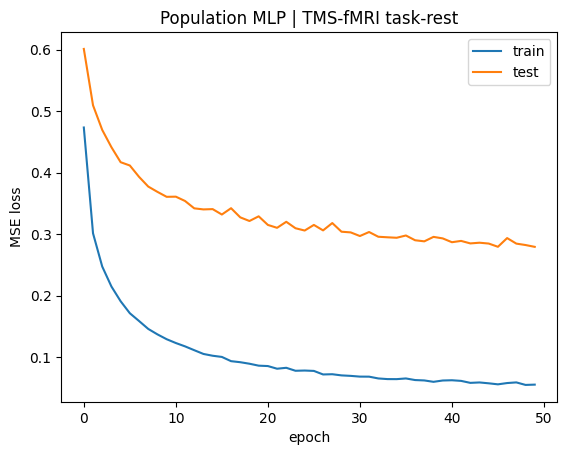

In [6]:

# --- Visualize learning curves ---

plt.figure()
plt.plot(train_loss, label="train")
plt.plot(test_loss, label="test")
plt.xlabel("epoch")
plt.ylabel("MSE loss")
plt.legend()
plt.title(f"Population {method} | TMS-fMRI task-rest")
plt.show()
